In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 12270, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 12270 (delta 5), reused 9 (delta 1), pack-reused 12250
Receiving objects: 100% (12270/12270), 12.02 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (8491/8491), done.
/content/yolov5
     |████████████████████████████████| 596 kB 28.9 MB/s 


In [2]:
%cd ..

/content


In [3]:
from torchvision.datasets.utils import download_url

In [4]:
download_url('https://github.com/ultralytics/yolov5/releases/download/v3.1/yolov5m.pt', '/content/yolov5/weights')

  0%|          | 0/43961205 [00:00<?, ?it/s]

In [5]:
import pandas as pd
import os
import cv2
import time
import random
import shutil
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_pickle('/content/drive/MyDrive/sections.pkl')

In [20]:
df['image_id'] = df['pdf'].apply(lambda x : x.split('.')[0])

In [21]:
df.head()

,pdf,width,height,slist,linelist,image_id
0,4545.pdf,595,842,NaN,"[{'x0': 33.301339386, 'y0': 813.8115126914636,...",4545
1,4522.pdf,595,842,NaN,"[{'x0': 33.301339386, 'y0': 813.8115126914636,...",4522
2,4551.pdf,595,842,NaN,"[{'x0': 33.301339386, 'y0': 813.8115126914636,...",4551
3,4531.pdf,595,842,NaN,"[{'x0': 33.301339386, 'y0': 813.8115126914636,...",4531
4,4499.pdf,595,842,NaN,"[{'x0': 33.301339386, 'y0': 813.8115126914636,...",4499


In [31]:
imagepath = '/content/drive/MyDrive/noisy_images'

(1000, 800, 3)
119.90599999999999


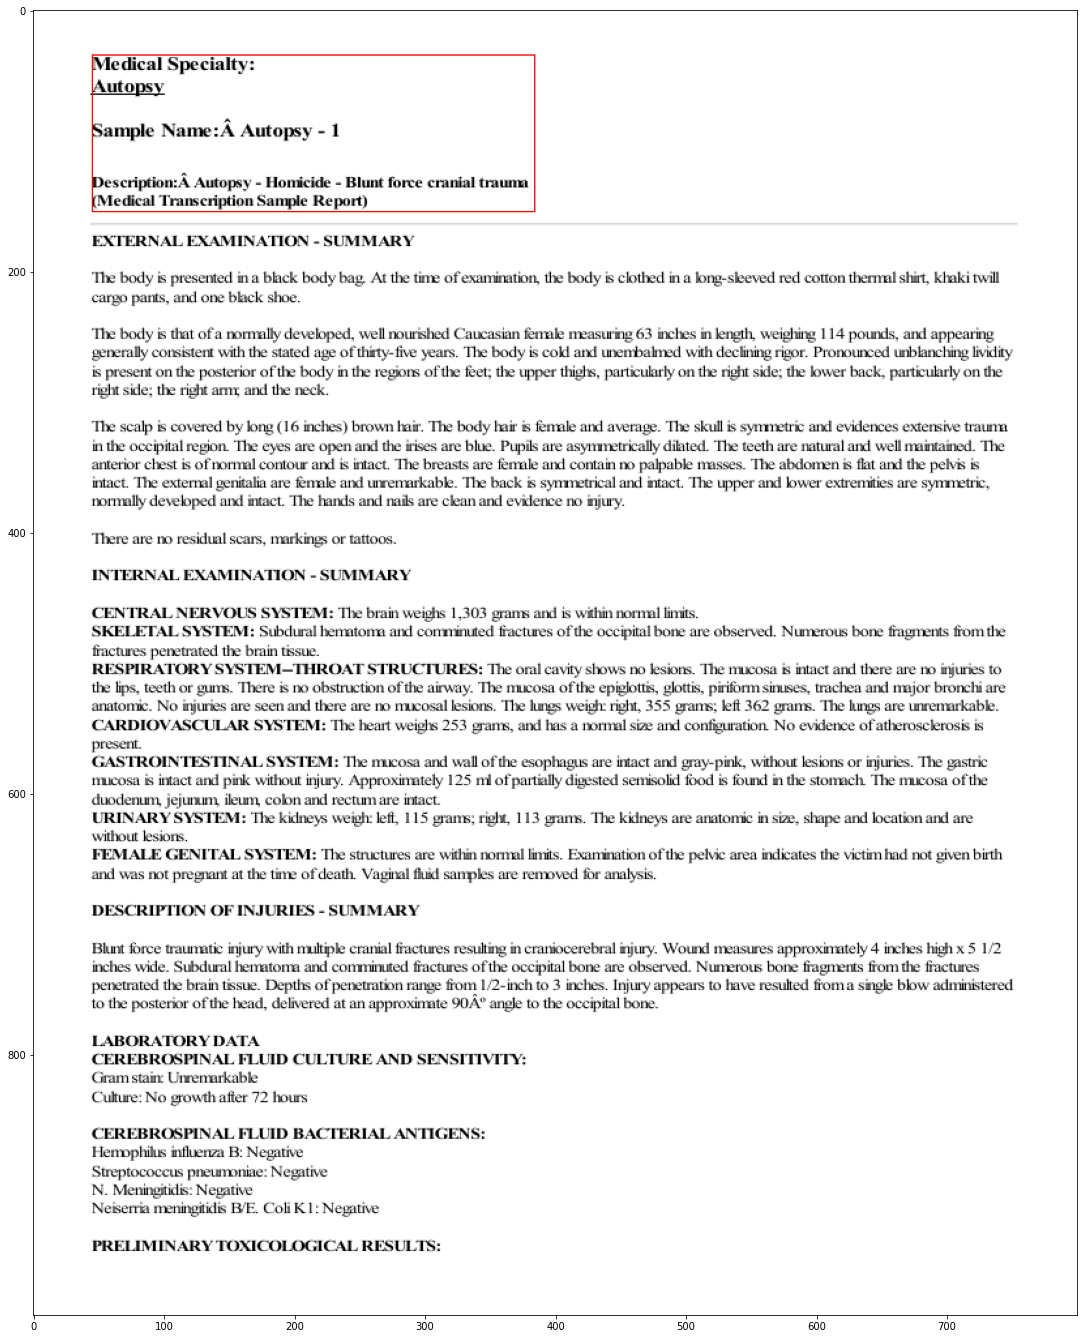

In [19]:
import math
plt.figure(figsize=(20,24))
index = 7
test_img = cv2.imread(os.path.join(imagepath))
test_img = cv2.cvtColor(test_img , cv2.COLOR_BGR2RGB)
print(test_img.shape)
x_scale, y_scale = (800/df.iloc[index]['width']), (1000/df.iloc[index]['height'])
word = df.iloc[index]['linelist']
idx = random.randint(0, len(word)-1)
x1 = math.ceil(word[idx]['x0']*x_scale)
y1 = 1000 - math.ceil(word[idx]['y0']*y_scale)
x2 = math.ceil(word[idx]['x1']*x_scale)
y2 = 1000 - math.ceil(word[idx]['y1']*y_scale)

x = 0.267417*800
y = (1-0.906569)*1000
w = 0.422897*800
h = 0.119906*1000
print(h)
test_img = cv2.rectangle(test_img, (math.ceil(x-w/2), math.ceil(y-h/2)), (math.ceil(x+w/2), math.ceil(y+h/2)), (255,0,0), 1)
plt.imshow(test_img)

In [24]:
train, test = train_test_split(df, test_size=0.2, random_state= 20, shuffle= True)

In [28]:
def yolo_anno(label_path, df):

  for index, row in tqdm(df.iterrows()):
    filename = row['pdf'].split('.')[0]
    x_scale, y_scale = (800/row.loc['width']), (1000/row.loc['height'])

    yolo_anno =[]
    
    for line in row['linelist']:
      category_id = 0

      x1 = line['x0']*x_scale
      y1 = line['y0']*y_scale
      x2 = line['x1']*x_scale
      y2 = line['y1']*y_scale

      x_center = ((x1+x2)/2)/800
      y_center = 1-((y1+y2)/2)/1000
      w = (x2-x1)/800
      h = (y1-y2)/1000
      yolo_anno.append([0, x_center, y_center, w, h])
    
    yolo_anno = np.array(yolo_anno)
    np.savetxt(os.path.join(f'{label_path}', f'{filename}.txt'), yolo_anno, fmt = ['%d', '%f', '%f', '%f', '%f'])

In [25]:
 train=train[0:1000]
 test=test[0:200]
 train.shape

(1000, 6)

In [29]:
yolo_anno('/content/drive/MyDrive/Yolo2/Yolo/Train/labels', train)

1000it [00:09, 100.45it/s]


In [30]:
yolo_anno('/content/drive/MyDrive/Yolo2/Yolo/Test/labels', test)

200it [00:02, 96.22it/s] 


In [33]:
directory='drive/MyDrive/Yolo2/Yolo/Train/labels'
for f in os.listdir(directory):
  f=f.split('.')[0]+".tiff"
  source = os.path.join(imagepath, f)
  destination = os.path.join('drive/MyDrive/Yolo2/Yolo/Train/images', f)
  shutil.copy(source, destination) 

In [18]:
%%writefile ./yolo_data.yaml

train: /content/drive/MyDrive/Yolo2/Yolo/Train/images
val: /content/drive/MyDrive/Yolo2/Yolo/Test/images
test: /content/drive/MyDrive/Yolo2/Yolo/Test/images
nc: 1

Writing ./yolo_data.yaml


In [8]:
%cd /content/yolov5

/content/yolov5


In [19]:
!python train.py --batch 8 --epochs 20 --cfg /content/yolov5/models/yolov5m.yaml --data /content/yolo_data.yaml --weights /content/yolov5_medium_fulldata/YOLOV5_Text4/weights/best.pt --project /content/yolov5_medium_fulldata  --name YOLOV5_Text 

train: weights=/content/yolov5_medium_fulldata/YOLOV5_Text4/weights/best.pt, cfg=/content/yolov5/models/yolov5m.yaml, data=/content/yolo_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/yolov5_medium_fulldata, name=YOLOV5_Text, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05,

In [10]:
! zip -r /content/drive/MyDrive/yolov5_medium_fulldata.zip /content/yolov5_medium_fulldata

updating: content/yolov5_medium_fulldata/ (stored 0%)
updating: content/yolov5_medium_fulldata/YOLOV5_Text/ (stored 0%)
updating: content/yolov5_medium_fulldata/YOLOV5_Text/hyp.yaml (deflated 45%)
updating: content/yolov5_medium_fulldata/YOLOV5_Text/opt.yaml (deflated 48%)
updating: content/yolov5_medium_fulldata/YOLOV5_Text/weights/ (stored 0%)
  adding: content/yolov5_medium_fulldata/YOLOV5_Text/events.out.tfevents.1655922328.6b7c972d0c0e.412.0 (deflated 5%)


In [23]:
! python detect.py --source /content/drive/MyDrive/noisy_images/9.tiff --weights /content/yolov5_medium_fulldata/YOLOV5_Text5/weights/best.pt

detect: weights=['/content/yolov5_medium_fulldata/YOLOV5_Text5/weights/best.pt'], source=/content/drive/MyDrive/noisy_images/9.tiff, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/noisy_images/9.tiff: 640x512 14 texts, Done. (0.023s)
Speed: 0.6ms pre-process, 22.5ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp8
